In [74]:
import pandas as pd
import numpy as np

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error

In [125]:
data = pd.read_csv('housing_dataset.csv', sep=',')

### Visualisations

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
Name: SalePrice, dtype: float64


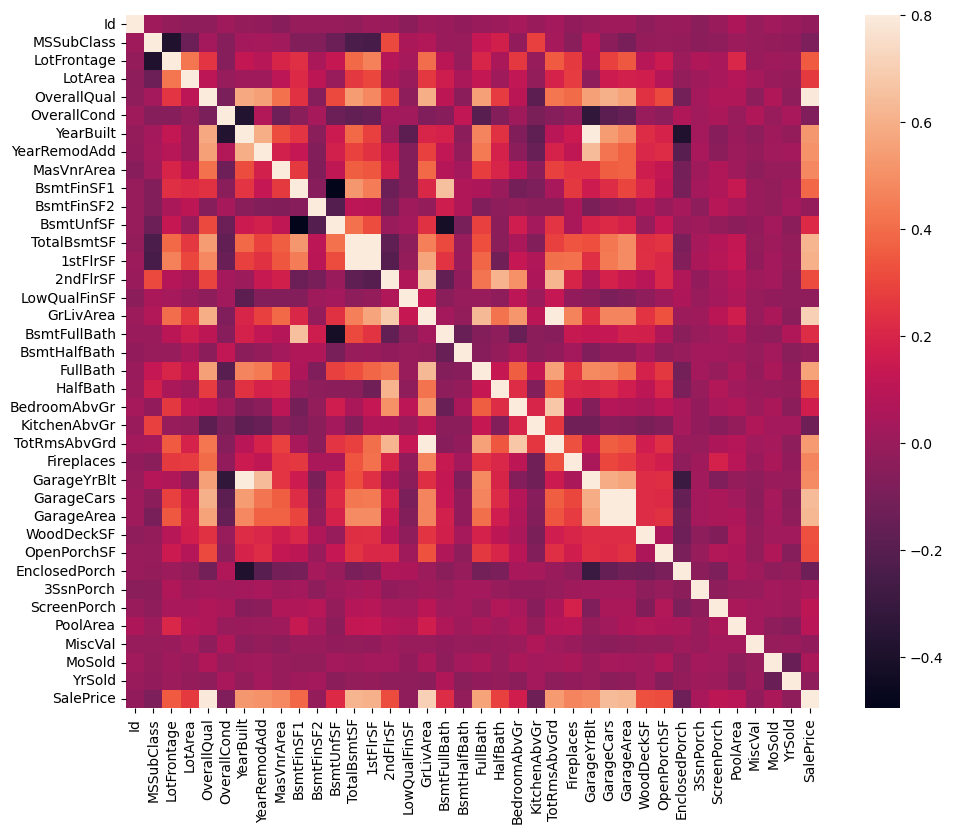

In [127]:
#Matrice de corrélation
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = data.corr()
corr_saleprice = corr_matrix['SalePrice'].sort_values(ascending=False)
print(corr_saleprice.head(20))
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=0.8, square=True)
plt.show()

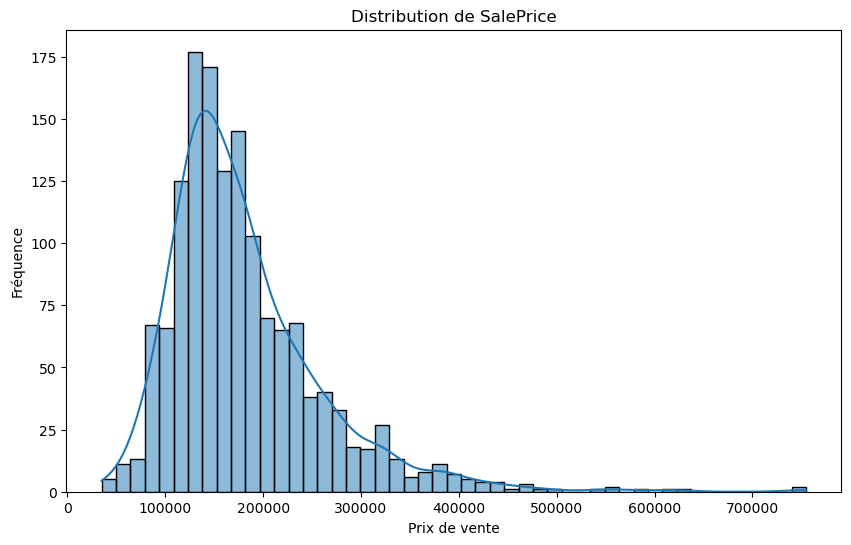

In [128]:
#Histogramme du prix de vente
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='SalePrice', kde=True)
plt.title('Distribution de SalePrice')
plt.xlabel('Prix de vente')
plt.ylabel('Fréquence')
plt.show()

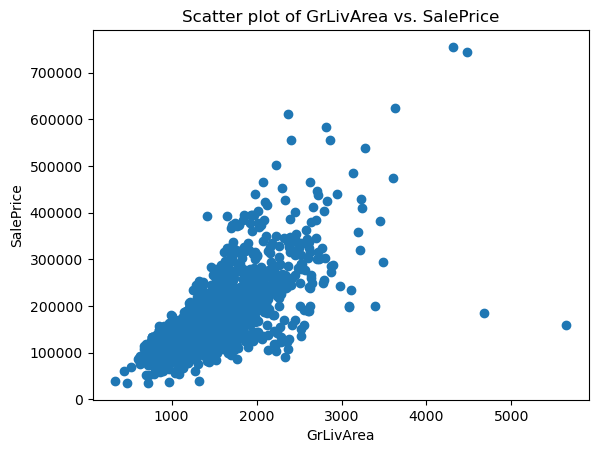

In [129]:
#Nuage de points entre SalePrice et GrLivArea
plt.scatter(data['GrLivArea'], data['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('Scatter plot of GrLivArea vs. SalePrice')
plt.show()

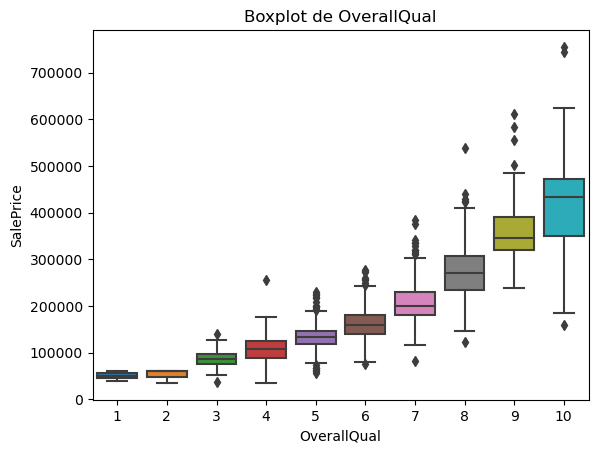

In [130]:
#Boxplot de OverallQual
sns.boxplot(x=data['OverallQual'], y=data['SalePrice'])
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('Boxplot de OverallQual')
plt.show()

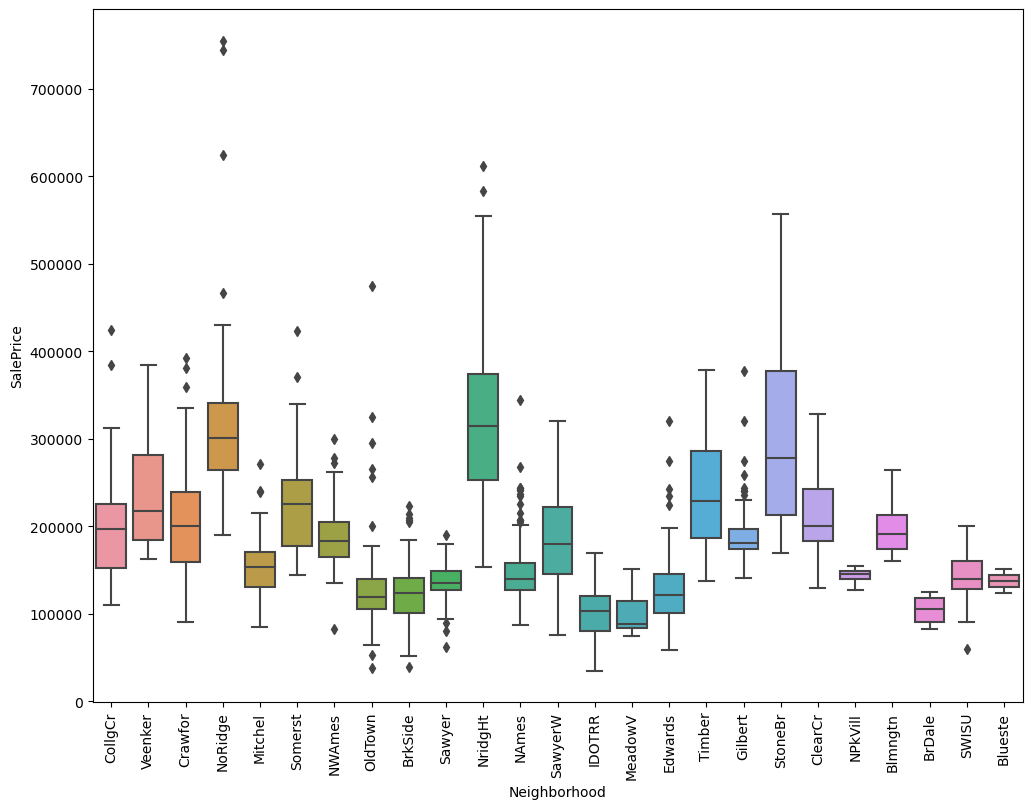

In [131]:
#Boxplot de SalePrice par Neighborhood 
plt.figure(figsize=(12, 9))
sns.boxplot(x='Neighborhood', y='SalePrice', data=data)
plt.xticks(rotation=90)
plt.show()

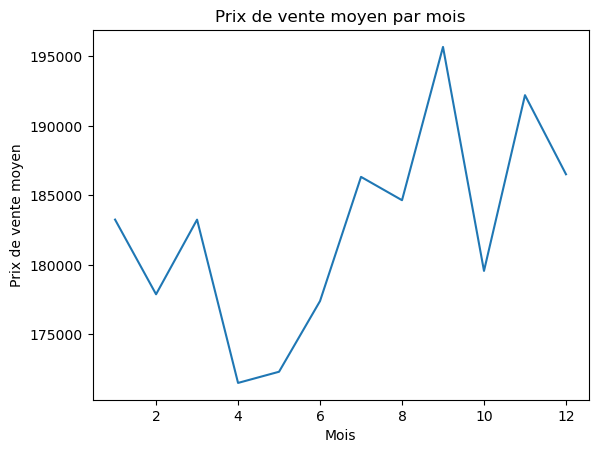

In [132]:
#Prix de vente moyen par mois
mean_sale_price_by_month = data.groupby('MoSold')['SalePrice'].mean()
plt.plot(mean_sale_price_by_month.index, mean_sale_price_by_month.values)

plt.xlabel('Mois')
plt.ylabel('Prix de vente moyen')
plt.title('Prix de vente moyen par mois')

plt.show()

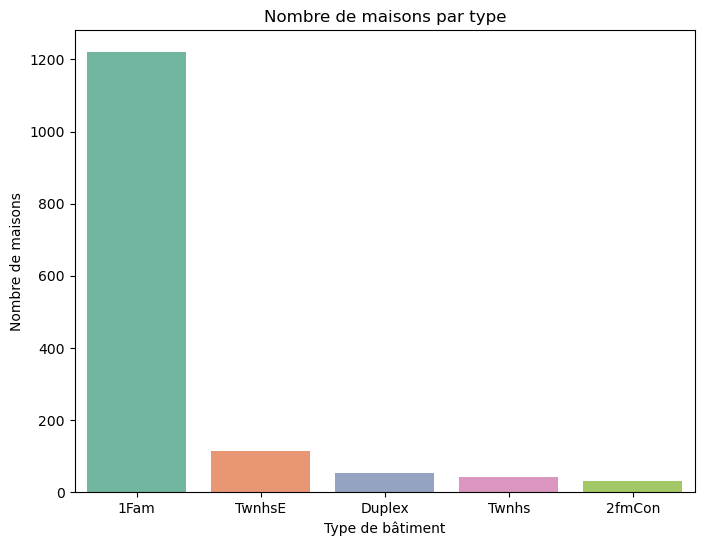

In [133]:
#Nombre de maisons par type
type_counts = data['BldgType'].value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette='Set2')
plt.title('Nombre de maisons par type')
plt.xlabel('Type de bâtiment')
plt.ylabel('Nombre de maisons')
plt.show()

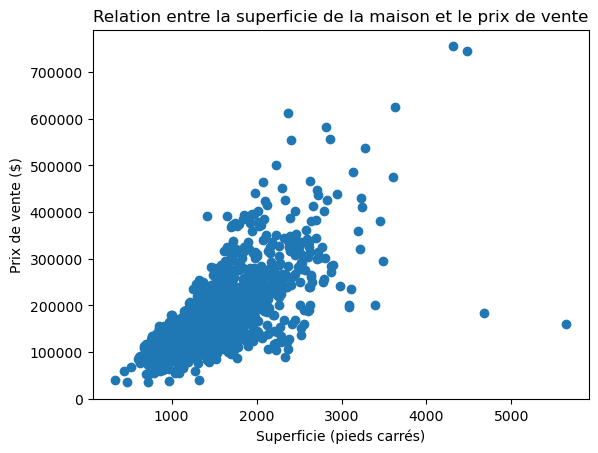

In [134]:
#Nuage de points montrant la relation entre la superficie de la maison et le prix de vente
x = data['GrLivArea']
y = data['SalePrice']
plt.scatter(x, y)
plt.title('Relation entre la superficie de la maison et le prix de vente')
plt.xlabel('Superficie (pieds carrés)')
plt.ylabel('Prix de vente ($)')
plt.show()

### Pré Processing

In [135]:
#Fonction pour compter les valeurs manquantes dans le dataset
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)
    print("Your selected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    return mis_val_table_ren_columns

missing_values_table(data)

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55


In [136]:
#Gestion NaN 
#On remplace les NaN par "NO" car le NaN correspond à l'absence de ces caractéristiques
for column in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageQual', 'GarageFinish', 'GarageCond', 'GarageType',
              'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrType']:
    data[column] = data[column].fillna('NO')
    
#On remplace les NaN par 0
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

In [137]:
#Normalisation LotFrontage
data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].median())

In [138]:
label_encoder = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = label_encoder.fit_transform(data[col].astype(str))

## Models

### Régression linéaire

In [139]:
# Sélectionner les colonnes utiles

#df = data[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd']]

df = data[["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea", "Neighborhood", "OverallQual", "YearBuilt",
          "YearRemodAdd", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea", "TotRmsAbvGrd", "GarageCars",
          "PoolQC"]]

# Supprimer les valeurs manquantes
df.dropna(inplace=True)

# Diviser les données en ensembles d'entraînement et de test
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer la précision du modèle
accuracy = r2_score(y_test, y_pred)
print("La précision du modèle (Regression Linéaire) est de :", accuracy)

# Calculer la MAE
mae = np.mean(np.abs(y_pred - y_test))
print("MAE : {:.2f}".format(mae))

# Calculer la MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("MAPE : {:.2f}%".format(mape))

La précision du modèle (Regression Linéaire) est de : 0.7926149028238174
MAE : 24770.97
MAPE : 14.77%


C:\Users\yacin\AppData\Local\Temp\ipykernel_33488\373275002.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


### Random forest

In [144]:
# Créer et entraîner le modèle
regr =  RandomForestRegressor()

# Effectuer la cross-validation avec 5 folds
scores = cross_val_score(model, X_train, y_train, cv=8, scoring='neg_mean_absolute_percentage_error')

# Afficher la MAPE moyenne et l'écart-type
mape_scores = -scores
print("MAPE (Cross Validation): %0.2f (+/- %0.2f)" % (mape_scores.mean(), mape_scores.std() * 2))

regr.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_rf = regr.predict(X_test)

# Calculer la précision du modèle
accuracy = r2_score(y_test, y_pred_rf)
print("La précision du modèle (Random Forest) est de :", accuracy)

# Calculer la MAE
mae = np.mean(np.abs(y_pred_rf - y_test))
print("MAE : {:.2f}".format(mae))

# Calculer la MAPE
mape = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
print("MAPE : {:.2f}%".format(mape))

MAPE (Cross Validation): 0.14 (+/- 0.04)
La précision du modèle (Random Forest) est de : 0.8862756318068153
MAE : 18382.00
MAPE : 11.26%


In [147]:
# Définition de la fonction pour prédire le prix
def predict_price(inputs):
    inputs = pd.DataFrame([inputs])
    prediction = regr.predict(inputs)
    return prediction[0]

In [149]:
def main():
    st.title("Prédiction de prix de maison")

    # Création des widgets pour l'entrée des données
    mssubclass = st.slider("MSSubClass", min_value=20, max_value=190, step=10)
    mszoning = st.selectbox("MSZoning", ["RL", "RM", "FV", "RH"])
    lotfrontage = st.number_input("LotFrontage", min_value=0, max_value=200)
    lotarea = st.number_input("LotArea", min_value=0, max_value=100000)
    neighborhood = st.selectbox("Neighborhood", ["CollgCr", "Veenker", "Crawfor", "NoRidge", "Mitchel"])
    overallqual = st.slider("OverallQual", min_value=1, max_value=10, step=1)
    yearbuilt = st.number_input("YearBuilt", min_value=1800, max_value=2023)
    yearremodadd = st.number_input("YearRemodAdd", min_value=1800, max_value=2023)
    totalbsmtsf = st.number_input("TotalBsmtSF", min_value=0, max_value=6000)
    firstflrsf = st.number_input("1stFlrSF", min_value=0, max_value=6000)
    secondflrsf = st.number_input("2ndFlrSF", min_value=0, max_value=6000)
    grlivarea = st.number_input("GrLivArea", min_value=0, max_value=8000)
    totrmsabvgrd = st.slider("TotRmsAbvGrd", min_value=1, max_value=15, step=1)
    garagecars = st.slider("GarageCars", min_value=0, max_value=10, step=1)
    poolqc = st.selectbox("PoolQC", ["NA", "Ex", "Fa", "Gd"])

    # Stockage des données en dictionnaire pour prédiction
    inputs = {
        "MSSubClass": mssubclass,
        "MSZoning": mszoning,
        "LotFrontage": lotfrontage,
        "LotArea": lotarea,
        "Neighborhood": neighborhood,
        "OverallQual": overallqual,
        "YearBuilt": yearbuilt
    }